## DSxH Assignment 1
Iris Vukovic\
\
The main task is to predict if the Length of Stay (LOS) of a patient in the ICU is short or long using two different strategies:\
(1) using the severity of illness score OASIS, and\
(2) using the values of some variables of the first hours of the stay in the ICU.

In [1033]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.ion()
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [1034]:
path = "/Users/irisvuko/Downloads/ds for health/mimic-iv-clinical-database-demo-2.2/" #path to the data folder 

### Questions
#### Question 1: 
Compute:\
a. the number of different patients in the dataset\
b. the number of different hospital admissions in the dataset\
c. the number of different ICU stays in the dataset 

### Load the ICUSTAYS table

In [1035]:
df_icustays = pd.read_csv(path+'icu/icustays.csv.gz')
print(df_icustays.shape)

(140, 8)


In [1036]:
num_patients = len(df_icustays['subject_id'].unique())
num_hadms = len(df_icustays['hadm_id'].unique())
num_icustays = len(df_icustays['stay_id'].unique())

print('number of different patients: ', num_patients)
print('number of different hospital admissions: ', num_hadms)
print('number of different ICU stays: ', num_icustays)

number of different patients:  100
number of different hospital admissions:  128
number of different ICU stays:  140


#### Question 2: 
Show with an example that we can find a patient with more than one ICU stay.

In [1037]:
v = df_icustays.subject_id.value_counts()
df_icustays[df_icustays.subject_id.isin(v.index[v.gt(1)])] 
#i believe this gets all the patients with more than 1 subject_id appearance in the datset
#https://stackoverflow.com/questions/48628417/how-to-select-rows-in-pandas-dataframe-where-value-appears-more-than-once

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
1,10020187,24104168,37509585,Neuro Surgical Intensive Care Unit (Neuro SICU),Neuro Stepdown,2169-01-15 04:56:00,2169-01-20 15:47:50,5.452662
2,10020187,26842957,32554129,Neuro Intermediate,Neuro Intermediate,2170-02-24 18:18:46,2170-02-25 15:15:26,0.872685
4,10020740,25826145,32145159,Trauma SICU (TSICU),Trauma SICU (TSICU),2150-06-03 20:12:32,2150-06-04 21:05:58,1.037106
5,10039708,23819016,38559363,Trauma SICU (TSICU),Trauma SICU (TSICU),2140-06-18 01:41:00,2140-06-19 21:47:16,1.837685
8,10018081,28861356,38333427,Trauma SICU (TSICU),Trauma SICU (TSICU),2134-08-05 14:53:33,2134-08-07 17:32:43,2.110532
...,...,...,...,...,...,...,...,...
132,10019003,27525946,35214014,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2153-04-13 19:45:30,2153-04-16 21:15:15,3.062326
134,10003400,20214994,32128372,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2137-02-25 23:37:19,2137-03-10 21:29:36,12.911308
136,10020740,23831430,35026312,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2150-03-11 15:34:56,2150-03-19 02:17:47,7.446424
138,10037928,24656677,39804682,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2178-12-21 06:05:18,2178-12-22 02:16:08,0.840856


An example patient with more than one ICU stay.

In [1038]:
df_icustays[df_icustays['subject_id'] == 10020187]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
1,10020187,24104168,37509585,Neuro Surgical Intensive Care Unit (Neuro SICU),Neuro Stepdown,2169-01-15 04:56:00,2169-01-20 15:47:50,5.452662
2,10020187,26842957,32554129,Neuro Intermediate,Neuro Intermediate,2170-02-24 18:18:46,2170-02-25 15:15:26,0.872685


#### Question 3: 
Explain the difference between 'intime' from ICUSTAYS table and 'admittime' from ADMISSIONS table.

'intime' from ICUSTAYS table is the date and time the patient was transferred into the ICU. 'admittime' from ADMISSIONS table is the date and time the patient was admitted into the hospital.\
\
https://mimic.mit.edu/docs/iv/modules/icu/icustays/\
https://mimic.mit.edu/docs/iv/modules/hosp/admissions/ 

### Exercise
Predict if the length of stay (LOS) of the ICU patients is "short" or "long" (binary classification problem) based on the severity score OASIS of: (1) the first 24 hours of an ICU stay and (2) the first 48 hours of an ICU stay.

### Extracting and Transforming

##### Compute the following variables:
-age\
-pre-LOS\
-elective surgery\
-Glasgow Coma Score (GCS) \
-heart rate\
-mean arterial pressure (MAP)\
-respiratory rate\
-temperature\
-urine output\
-ventilated\
\
and save them in separate csv files. Each csv file should contain a dataframe with: [subject_id, hadm_id, icustay_id, variable_Time and variable value], except for ventilation.

##### Load tables PATIENTS, ADMISSIONS, ICUSTAYS, CHARTEVENTS, PROCEDUREEVENTS, OUTPUTEVENTS, and D_ITEMS

In [1039]:
#load patients table
df_patients = pd.read_csv(path+'hosp/patients.csv.gz')
print(df_patients.shape)

(100, 6)


In [1040]:
#load admissions table
df_admissions = pd.read_csv(path+'hosp/admissions.csv.gz')
print(df_admissions.shape)

(275, 16)


In [1041]:
#load chartevents table
df_chartevents = pd.read_csv(path+'icu/chartevents.csv.gz')
print(df_chartevents.shape)

(668862, 11)


In [1042]:
#load procedureevents table
df_procedureevents = pd.read_csv(path+'icu/procedureevents.csv.gz')
print(df_procedureevents.shape)

(1468, 22)


In [1043]:
#load outputevents table
df_outputevents = pd.read_csv(path+'icu/outputevents.csv.gz')
print(df_outputevents.shape)

(9362, 9)


In [1044]:
#load d_items table
df_ditems = pd.read_csv(path+'icu/d_items.csv.gz')
print(df_ditems.shape)

(4014, 9)


##### Merge tables PATIENTS, ADMISSIONS, ICUSTAYS, CHARTEVENTS, PROCEDREEVENTS and OUTPUTEVENTS.

##### Age

formula: Age = anchor_age + (intime − anchor_year).

In [1045]:
#merge patients and icu_stays on subject_id
age_df = pd.merge(df_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime']],
                  df_patients[['subject_id', 'anchor_age', 'anchor_year']], 
                  on='subject_id', 
                  how='left')

#calculate age at the time of ICU admission
age_df['age_at_intime'] = age_df['anchor_age'] + (pd.to_datetime(age_df['intime']).dt.year - age_df['anchor_year'])

age_df['age_time'] = age_df['intime']
age_df['age'] = age_df['age_at_intime']

age_df = age_df[['subject_id', 'hadm_id', 'stay_id', 'age_time', 'age']]

age_df

,subject_id,hadm_id,stay_id,age_time,age
0,10018328,23786647,31269608,2154-04-24 23:03:44,83
1,10020187,24104168,37509585,2169-01-15 04:56:00,63
2,10020187,26842957,32554129,2170-02-24 18:18:46,64
3,10012853,27882036,31338022,2176-11-26 02:34:49,92
4,10020740,25826145,32145159,2150-06-03 20:12:32,56
...,...,...,...,...,...
135,10020786,23488445,33683112,2189-06-09 12:46:30,86
136,10020740,23831430,35026312,2150-03-11 15:34:56,56
137,10032725,20611640,30101877,2143-03-22 06:42:00,38
138,10037928,24656677,39804682,2178-12-21 06:05:18,81


In [1046]:
age_df.to_csv('age_at_icu_admission.csv', index=False)


##### Pre-LOS

In [1047]:
#merge patients and icu_stays on subject_id
prelos_df = pd.merge(df_icustays[['subject_id','hadm_id', 'stay_id', 'intime']], 
                     df_admissions[['subject_id', 'hadm_id','admittime']],
                     on=['subject_id', 'hadm_id'], 
                     how='left')

#calculate age at the time of ICU admission
prelos_df['prelos_time'] = (pd.to_datetime(prelos_df['intime']) - pd.to_datetime(prelos_df['admittime'])).dt.total_seconds() / 3600

#prelos_df['prelos_time'] = (pd.to_datetime(prelos_df['admittime']) - pd.to_datetime(prelos_df['intime'])).dt.total_seconds() / 3600
prelos_df['prelos'] = prelos_df['prelos_time']

prelos_df = prelos_df[['subject_id', 'hadm_id', 'stay_id', 'prelos_time', 'prelos']]

prelos_df

,subject_id,hadm_id,stay_id,prelos_time,prelos
0,10018328,23786647,31269608,19.812222,19.812222
1,10020187,24104168,37509585,0.866667,0.866667
2,10020187,26842957,32554129,18.312778,18.312778
3,10012853,27882036,31338022,5.113611,5.113611
4,10020740,25826145,32145159,0.008889,0.008889
...,...,...,...,...,...
135,10020786,23488445,33683112,0.025000,0.025000
136,10020740,23831430,35026312,0.015556,0.015556
137,10032725,20611640,30101877,1.716667,1.716667
138,10037928,24656677,39804682,0.588333,0.588333


In [1048]:
prelos_df.to_csv('pre_los.csv', index=False)

##### Elective Surgery

In [1049]:
#merge again
elective_surg_df = pd.merge(df_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime']], 
                  df_admissions[['subject_id', 'hadm_id','admittime' , 'admission_type']], 
                  on=['subject_id','hadm_id'], 
                  how='left')

elective_surg_df['admission_time'] = (pd.to_datetime(elective_surg_df['admittime']) - pd.to_datetime(elective_surg_df['intime'])).dt.total_seconds() / 3600
elective_surg_df['admission_type'] = elective_surg_df['admission_type'].str.strip().str.lower()

admission_rename = {
    'elective': 'elective',
    'urgent' : 'urgent',
    'ew emer.' : 'emergency',
    'direct emer.' : 'emergency',
    'eu observation' : 'other',
    'observation admit' : 'other',
    'surgical same day admission' : 'elective',
    'direct observation' : 'other',
    'ambulatory observation' : 'other'
}

elective_surg_df['admission_type'] = elective_surg_df['admission_type'].replace(admission_rename)

elective_surg_df = elective_surg_df[['subject_id', 'hadm_id', 'stay_id', 'admission_time', 'admission_type']]

elective_surg_df

,subject_id,hadm_id,stay_id,admission_time,admission_type
0,10018328,23786647,31269608,-19.812222,elective
1,10020187,24104168,37509585,-0.866667,other
2,10020187,26842957,32554129,-18.312778,elective
3,10012853,27882036,31338022,-5.113611,emergency
4,10020740,25826145,32145159,-0.008889,emergency
...,...,...,...,...,...
135,10020786,23488445,33683112,-0.025000,urgent
136,10020740,23831430,35026312,-0.015556,urgent
137,10032725,20611640,30101877,-1.716667,emergency
138,10037928,24656677,39804682,-0.588333,emergency


In [1050]:
elective_surg_df.to_csv('elective_surg.csv', index=False)

##### Temperature

In [1051]:
df_ditems.loc[df_ditems.label.str.contains('Temperature', case=False, na=False, regex=False)]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
415,224674,Changes in Temperature,Changes in Temperature,chartevents,Toxicology,NaN,Text,NaN,NaN
1177,224027,Skin Temperature,Skin Temp,chartevents,Skin - Assessment,NaN,Text,NaN,NaN
1564,224642,Temperature Site,Temp Site,chartevents,Routine Vital Signs,NaN,Text,NaN,NaN
1957,228242,Pt. Temperature (BG) (SOFT),Pt. Temperature (BG) (SOFT),chartevents,Labs,NaN,Numeric,NaN,NaN
2397,229236,Cerebral Temperature (C),Cerebral T (C),chartevents,Hemodynamics,°C,Numeric,NaN,NaN
2570,223761,Temperature Fahrenheit,Temperature F,chartevents,Routine Vital Signs,°F,Numeric,NaN,NaN
2573,223762,Temperature Celsius,Temperature C,chartevents,Routine Vital Signs,°C,Numeric,NaN,NaN
2578,226329,Blood Temperature CCO (C),Blood Temp CCO (C),chartevents,Routine Vital Signs,°C,Numeric,NaN,NaN
2633,227054,TemperatureF_ApacheIV,TemperatureF_ApacheIV,chartevents,Scores - APACHE IV (2),°F,Numeric,NaN,NaN


In [1052]:
#load chartevents table
df_chartevents = pd.read_csv(path+'icu/chartevents.csv.gz')

#merge again
temperature_df = pd.merge(df_chartevents[df_chartevents['itemid'].isin([223761,223762])][['subject_id', 'hadm_id', 'stay_id','value', 'charttime', 'itemid']],
                df_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime']],  
                on=['subject_id', 'hadm_id', 'stay_id'], 
                how='left')

temperature_df['temp_time'] = (pd.to_datetime(temperature_df['charttime']) - pd.to_datetime(temperature_df['intime'])).dt.total_seconds() / 3600
temperature_df['temp_c'] = temperature_df['value']

temperature_df = temperature_df[['subject_id', 'hadm_id', 'stay_id', 'temp_time', 'temp_c', 'itemid']]

temperature_df

,subject_id,hadm_id,stay_id,temp_time,temp_c,itemid
0,10005817,20626031,32604416,14.516389,37,223762
1,10005817,20626031,32604416,15.516389,37,223762
2,10005817,20626031,32604416,16.516389,37.1,223762
3,10005817,20626031,32604416,17.516389,37,223762
4,10005817,20626031,32604416,18.516389,37.1,223762
...,...,...,...,...,...,...
3765,10019003,29279905,34107647,72.650000,100.2,223761
3766,10019003,29279905,34107647,78.650000,98.4,223761
3767,10019003,29279905,34107647,81.650000,98.4,223761
3768,10019003,29279905,34107647,35.150000,99.2,223761


Converting the Farenheit measurements to Celsius

In [1053]:
temperature_df['temp_c'] = pd.to_numeric(temperature_df['temp_c'], errors='coerce')

temperature_df.loc[temperature_df['itemid'] == 223761, 'temp_c'] = (
    (temperature_df.loc[temperature_df['itemid'] == 223761, 'temp_c'] - 32) * 5 / 9).round(1)

temperature_df = temperature_df[['subject_id', 'hadm_id', 'stay_id', 'temp_time', 'temp_c']]

temperature_df

,subject_id,hadm_id,stay_id,temp_time,temp_c
0,10005817,20626031,32604416,14.516389,37.0
1,10005817,20626031,32604416,15.516389,37.0
2,10005817,20626031,32604416,16.516389,37.1
3,10005817,20626031,32604416,17.516389,37.0
4,10005817,20626031,32604416,18.516389,37.1
...,...,...,...,...,...
3765,10019003,29279905,34107647,72.650000,37.9
3766,10019003,29279905,34107647,78.650000,36.9
3767,10019003,29279905,34107647,81.650000,36.9
3768,10019003,29279905,34107647,35.150000,37.3


In [1054]:
temperature_df.to_csv('temperature.csv', index=False)

In [1055]:
temperature_df_24h = temperature_df[temperature_df['temp_time'] <= 24]
temperature_df_48h = temperature_df[temperature_df['temp_time'] <= 48]
temperature_df_24h.to_csv('temperature_24.csv', index=False)
temperature_df_48h.to_csv('temperature_48.csv', index=False)

In [1056]:
temperature_df_24h

,subject_id,hadm_id,stay_id,temp_time,temp_c
0,10005817,20626031,32604416,14.516389,37.0
1,10005817,20626031,32604416,15.516389,37.0
2,10005817,20626031,32604416,16.516389,37.1
3,10005817,20626031,32604416,17.516389,37.0
4,10005817,20626031,32604416,18.516389,37.1
...,...,...,...,...,...
3748,10019003,29279905,34107647,12.650000,36.9
3749,10019003,29279905,34107647,13.650000,36.6
3750,10019003,29279905,34107647,17.650000,36.8
3751,10019003,29279905,34107647,21.650000,36.8


##### Heart rate

In [1057]:
df_ditems.loc[df_ditems.label.str.contains('Heart Rate', case=False, na=False, regex=False)]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
2054,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN
2063,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
2577,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN


In [1058]:
#load chartevents table
df_chartevents = pd.read_csv(path+'icu/chartevents.csv.gz')

#merge again
heartrate_df = pd.merge(df_chartevents[df_chartevents['itemid'] == 220045][['subject_id', 'hadm_id', 'stay_id', 'valuenum', 'charttime']], 
                df_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime']], 
                on=['subject_id', 'hadm_id', 'stay_id'], 
                how='left')

heartrate_df['hrate_time'] = (pd.to_datetime(heartrate_df['charttime']) - pd.to_datetime(heartrate_df['intime'])).dt.total_seconds() / 3600
heartrate_df['hrate'] = heartrate_df['valuenum']

heartrate_df = heartrate_df[['subject_id', 'hadm_id', 'stay_id', 'hrate_time', 'hrate']]

heartrate_df

,subject_id,hadm_id,stay_id,hrate_time,hrate
0,10005817,20626031,32604416,14.516389,80.0
1,10005817,20626031,32604416,15.516389,82.0
2,10005817,20626031,32604416,16.516389,80.0
3,10005817,20626031,32604416,17.516389,78.0
4,10005817,20626031,32604416,18.516389,84.0
...,...,...,...,...,...
13908,10019003,29279905,34107647,43.700000,121.0
13909,10019003,29279905,34107647,6.150000,106.0
13910,10019003,29279905,34107647,0.333333,103.0
13911,10019003,29279905,34107647,0.583333,100.0


In [1059]:
heartrate_df.to_csv('heartrate.csv', index=False)

In [1060]:
heartrate_df_24h = heartrate_df[heartrate_df['hrate_time'] <= 24]
heartrate_df_48h = heartrate_df[heartrate_df['hrate_time'] <= 48]
heartrate_df_24h.to_csv('heartrate_24.csv', index=False)
heartrate_df_48h.to_csv('heartrate_48.csv', index=False)

In [1061]:
heartrate_df_24h

,subject_id,hadm_id,stay_id,hrate_time,hrate
0,10005817,20626031,32604416,14.516389,80.0
1,10005817,20626031,32604416,15.516389,82.0
2,10005817,20626031,32604416,16.516389,80.0
3,10005817,20626031,32604416,17.516389,78.0
4,10005817,20626031,32604416,18.516389,84.0
...,...,...,...,...,...
13846,10019003,29279905,34107647,23.650000,103.0
13909,10019003,29279905,34107647,6.150000,106.0
13910,10019003,29279905,34107647,0.333333,103.0
13911,10019003,29279905,34107647,0.583333,100.0


##### Respiratory rate

In [1062]:
df_ditems.loc[df_ditems.label.str.contains('Respiratory Rate', case=False, na=False, regex=False)]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
2284,224688,Respiratory Rate (Set),Respiratory Rate (Set),chartevents,Respiratory,insp/min,Numeric,NaN,NaN
2314,224690,Respiratory Rate (Total),Respiratory Rate (Total),chartevents,Respiratory,insp/min,Numeric,NaN,36.0
2329,220210,Respiratory Rate,RR,chartevents,Respiratory,insp/min,Numeric,NaN,NaN
2344,224689,Respiratory Rate (spontaneous),Respiratory Rate (spontaneous),chartevents,Respiratory,insp/min,Numeric,NaN,NaN


In [1063]:
#load chartevents table
df_chartevents = pd.read_csv(path+'icu/chartevents.csv.gz')

#merge again
resprate_df = pd.merge(df_chartevents[df_chartevents['itemid'] == 220210][['subject_id', 'hadm_id', 'stay_id', 'valuenum', 'charttime']], 
                df_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime']], 
                on=['subject_id', 'hadm_id', 'stay_id'], 
                how='left')

resprate_df['resp_rate_time'] = (pd.to_datetime(resprate_df['charttime']) - pd.to_datetime(resprate_df['intime'])).dt.total_seconds() / 3600
resprate_df['resp_rate'] = resprate_df['valuenum']

resprate_df = resprate_df[['subject_id', 'hadm_id', 'stay_id', 'resp_rate_time', 'resp_rate']]

resprate_df

,subject_id,hadm_id,stay_id,resp_rate_time,resp_rate
0,10005817,20626031,32604416,14.516389,19.0
1,10005817,20626031,32604416,15.516389,18.0
2,10005817,20626031,32604416,16.516389,17.0
3,10005817,20626031,32604416,17.516389,16.0
4,10005817,20626031,32604416,18.516389,24.0
...,...,...,...,...,...
13908,10019003,29279905,34107647,43.766667,33.0
13909,10019003,29279905,34107647,6.150000,22.0
13910,10019003,29279905,34107647,0.333333,23.0
13911,10019003,29279905,34107647,0.583333,24.0


In [1064]:
resprate_df.to_csv('resprate.csv', index=False)

In [1065]:
resprate_df_24h = resprate_df[resprate_df['resp_rate_time'] <= 24]
resprate_df_48h = resprate_df[resprate_df['resp_rate_time'] <= 48]
resprate_df_24h.to_csv('resprate_24.csv', index=False)
resprate_df_48h.to_csv('resprate_48.csv', index=False)

In [1066]:
resprate_df_24h

,subject_id,hadm_id,stay_id,resp_rate_time,resp_rate
0,10005817,20626031,32604416,14.516389,19.0
1,10005817,20626031,32604416,15.516389,18.0
2,10005817,20626031,32604416,16.516389,17.0
3,10005817,20626031,32604416,17.516389,16.0
4,10005817,20626031,32604416,18.516389,24.0
...,...,...,...,...,...
13846,10019003,29279905,34107647,23.650000,27.0
13909,10019003,29279905,34107647,6.150000,22.0
13910,10019003,29279905,34107647,0.333333,23.0
13911,10019003,29279905,34107647,0.583333,24.0


##### Mean arterial pressure (MAP)

In [1067]:
df_ditems[df_ditems['itemid'] == 225312]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
2588,225312,ART BP Mean,ART BP Mean,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN


In [1068]:
df_ditems.loc[df_ditems.label.str.contains('Arterial Blood Pressure', case=False, na=False, regex=False)]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
2055,220058,Arterial Blood Pressure Alarm - High,ABP Alarm - High,chartevents,Alarms,mmHg,Numeric,NaN,NaN
2057,220056,Arterial Blood Pressure Alarm - Low,ABP Alarm - Low,chartevents,Alarms,mmHg,Numeric,NaN,NaN
2566,220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
2572,220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60.0,90.0
2586,220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90.0,140.0


In [1069]:
#load chartevents table
df_chartevents = pd.read_csv(path+'icu/chartevents.csv.gz')

#merge again
map_df = pd.merge(df_chartevents[df_chartevents['itemid'].isin([220052, 225312])][['subject_id', 'hadm_id', 'stay_id', 'valuenum', 'charttime']], 
                  df_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime']], 
                  on=['subject_id', 'hadm_id', 'stay_id'], 
                  how='left')

map_df['map_time'] = (pd.to_datetime(map_df['charttime']) - pd.to_datetime(map_df['intime'])).dt.total_seconds() / 3600
map_df['MAP'] = map_df['valuenum']

map_df = map_df[['subject_id', 'hadm_id', 'stay_id', 'map_time', 'MAP']]

map_df

,subject_id,hadm_id,stay_id,map_time,MAP
0,10005817,20626031,32604416,14.516389,58.0
1,10005817,20626031,32604416,15.516389,63.0
2,10005817,20626031,32604416,16.516389,58.0
3,10005817,20626031,32604416,17.516389,59.0
4,10005817,20626031,32604416,18.516389,66.0
...,...,...,...,...,...
6043,10018081,28861356,38333427,2.607500,330.0
6044,10018081,28861356,38333427,6.607500,57.0
6045,10018081,28861356,38333427,3.640833,71.0
6046,10018081,28861356,38333427,24.824167,89.0


In [1070]:
map_df.to_csv('map.csv', index=False)

In [1071]:
map_df_24h = map_df[map_df['map_time'] <= 24]
map_df_48h = map_df[map_df['map_time'] <= 48]
map_df_24h.to_csv('map_24.csv', index=False)
map_df_48h.to_csv('map_48.csv', index=False)

In [1072]:
map_df_24h

,subject_id,hadm_id,stay_id,map_time,MAP
0,10005817,20626031,32604416,14.516389,58.0
1,10005817,20626031,32604416,15.516389,63.0
2,10005817,20626031,32604416,16.516389,58.0
3,10005817,20626031,32604416,17.516389,59.0
4,10005817,20626031,32604416,18.516389,66.0
...,...,...,...,...,...
6042,10018081,28861356,38333427,1.607500,0.0
6043,10018081,28861356,38333427,2.607500,330.0
6044,10018081,28861356,38333427,6.607500,57.0
6045,10018081,28861356,38333427,3.640833,71.0


##### Glasgow Coma Score (GCS)

In [1073]:
df_ditems.loc[df_ditems.label.str.contains('GCS', case=False, na=False, regex=False)]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
621,223901,GCS - Motor Response,Motor Response,chartevents,Neurological,NaN,Text,NaN,NaN
627,223900,GCS - Verbal Response,Verbal Response,chartevents,Neurological,NaN,Text,NaN,NaN
639,220739,GCS - Eye Opening,Eye Opening,chartevents,Neurological,NaN,Text,NaN,NaN
1494,228112,GCSVerbalApacheIIValue (intubated),GCSVerbalApacheIIValue (intubated),chartevents,Scores - APACHE II,NaN,Text,NaN,NaN
1495,226757,GCSMotorApacheIIValue,GCSMotorApacheIIValue,chartevents,Scores - APACHE II,NaN,Text,NaN,NaN
1497,226758,GCSVerbalApacheIIValue,GCSVerbalApacheIIValue,chartevents,Scores - APACHE II,NaN,Text,NaN,NaN
1500,226756,GCSEyeApacheIIValue,GCSEyeApacheIIValue,chartevents,Scores - APACHE II,NaN,Text,NaN,NaN
1574,227011,GCSEye_ApacheIV,GCSEye_ApacheIV,chartevents,Scores - APACHE IV (2),NaN,Text,NaN,NaN
1576,227012,GCSMotor_ApacheIV,GCSMotor_ApacheIV,chartevents,Scores - APACHE IV (2),NaN,Text,NaN,NaN
1577,227014,GCSVerbal_ApacheIV,GCSVerbal_ApacheIV,chartevents,Scores - APACHE IV (2),NaN,Text,NaN,NaN


In [1074]:
df_chartevents[df_chartevents['itemid'] ==  223901].head()

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
63,10005817,20626031,32604416,6770.0,2132-12-16 00:00:00,2132-12-15 23:46:00,223901,Obeys Commands,6.0,NaN,0.0
295,10005817,20626031,32604416,79166.0,2132-12-16 08:00:00,2132-12-16 09:26:00,223901,Obeys Commands,6.0,NaN,0.0
533,10005817,20626031,32604416,79166.0,2132-12-16 12:00:00,2132-12-16 13:01:00,223901,Obeys Commands,6.0,NaN,0.0
660,10005817,20626031,32604416,79166.0,2132-12-16 16:00:00,2132-12-16 16:35:00,223901,Obeys Commands,6.0,NaN,0.0
783,10005817,20626031,32604416,4793.0,2132-12-16 20:00:00,2132-12-16 19:53:00,223901,Obeys Commands,6.0,NaN,0.0


In [1075]:
#load chartevents table
df_chartevents = pd.read_csv(path+'icu/chartevents.csv.gz')

eye =  df_chartevents[df_chartevents['itemid'] == 220739][['subject_id', 'hadm_id', 'stay_id', 'valuenum', 'charttime']]
verbal =  df_chartevents[df_chartevents['itemid'] == 223900][['subject_id', 'hadm_id', 'stay_id', 'valuenum', 'charttime']]
motor =  df_chartevents[df_chartevents['itemid'] == 223901][['subject_id', 'hadm_id', 'stay_id', 'valuenum', 'charttime']]

motor = motor.rename(columns={'valuenum': 'valuenum_motor'})

gcs_df = pd.merge(eye[['subject_id', 'hadm_id', 'stay_id', 'valuenum', 'charttime']],
                  verbal[['subject_id', 'hadm_id', 'stay_id',  'valuenum', 'charttime']],
                  on=['subject_id', 'hadm_id', 'stay_id','charttime'], 
                  how='left', suffixes=('_eye', '_verbal'))

gcs_df = pd.merge(gcs_df, motor[['subject_id', 'hadm_id', 'stay_id', 'valuenum_motor', 'charttime']],
                  on=['subject_id', 'hadm_id', 'stay_id', 'charttime'], 
                  how='left')

gcs_df = pd.merge(gcs_df, df_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime']], 
                  on=['subject_id', 'hadm_id', 'stay_id'], 
                  how='left')

gcs_df['gcs_time'] = (pd.to_datetime(gcs_df['charttime']) - pd.to_datetime(gcs_df['intime'])).dt.total_seconds() / 3600
gcs_df['GCS_total'] = gcs_df[['valuenum_eye', 'valuenum_verbal', 'valuenum_motor']].sum(axis=1)


gcs_df = gcs_df[['subject_id', 'hadm_id', 'stay_id', 'gcs_time', 'GCS_total']]

gcs_df

,subject_id,hadm_id,stay_id,gcs_time,GCS_total
0,10005817,20626031,32604416,14.516389,14.0
1,10005817,20626031,32604416,22.516389,15.0
2,10005817,20626031,32604416,26.516389,15.0
3,10005817,20626031,32604416,30.516389,15.0
4,10005817,20626031,32604416,34.516389,15.0
...,...,...,...,...,...
3269,10019003,29279905,34107647,18.016667,15.0
3270,10019003,29279905,34107647,38.050000,15.0
3271,10019003,29279905,34107647,30.216667,15.0
3272,10019003,29279905,34107647,63.550000,15.0


In [1076]:
gcs_df_24h = gcs_df[gcs_df['gcs_time'] <= 24]
gcs_df_48h = gcs_df[gcs_df['gcs_time'] <= 48]

In [1077]:
#calculate the minimum gcs_sum for each group
gcs_df_24h['min_gcs_sum'] = gcs_df_24h.groupby(['subject_id', 'hadm_id', 'stay_id'])['GCS_total'].transform('min')
gcs_df_48h['min_gcs_sum'] = gcs_df_48h.groupby(['subject_id', 'hadm_id', 'stay_id'])['GCS_total'].transform('min')

#filter rows where gcs_sum equals the minimum value for each group
gcs_df_24_min = gcs_df_24h[gcs_df_24h['GCS_total'] == gcs_df_24h['min_gcs_sum']]
gcs_df_48_min = gcs_df_48h[gcs_df_48h['GCS_total'] == gcs_df_48h['min_gcs_sum']]

#ensure we can keep the row with the earliest charttime
gcs_df_24_min = gcs_df_24_min.sort_values(by=['subject_id', 'hadm_id', 'stay_id', 'gcs_time'])
gcs_df_48_min = gcs_df_48_min.sort_values(by=['subject_id', 'hadm_id', 'stay_id', 'gcs_time'])

#drop duplicates, keeping only earliest charttime
gcs_df_24_min = gcs_df_24_min.drop_duplicates(subset=['subject_id', 'hadm_id', 'stay_id'], keep='first')
gcs_df_48_min = gcs_df_48_min.drop_duplicates(subset=['subject_id', 'hadm_id', 'stay_id'], keep='first')

gcs_df_24_min = gcs_df_24_min.drop(columns='min_gcs_sum')
gcs_df_48_min = gcs_df_48_min.drop(columns='min_gcs_sum')

gcs_df_24_min

/var/folders/ph/hryvf5m94jx0bs4j7nxpwrfr0000gn/T/ipykernel_913/702993906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcs_df_24h['min_gcs_sum'] = gcs_df_24h.groupby(['subject_id', 'hadm_id', 'stay_id'])['GCS_total'].transform('min')
/var/folders/ph/hryvf5m94jx0bs4j7nxpwrfr0000gn/T/ipykernel_913/702993906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcs_df_48h['min_gcs_sum'] = gcs_df_48h.groupby(['subject_id', 'hadm_id', 'stay_id'])['GCS_total'].transform('min')


,subject_id,hadm_id,stay_id,gcs_time,GCS_total
2391,10000032,29079034,39553978,0.750000,14.0
793,10001217,24597018,37067082,0.199444,15.0
325,10001217,27703517,34592300,0.926667,15.0
1453,10001725,25563031,31205490,0.127222,15.0
2466,10002428,20321825,34807493,8.550000,11.0
...,...,...,...,...,...
124,10039708,24928679,37323533,12.318056,14.0
579,10039708,28258130,33281088,-0.133333,9.0
1465,10039831,26924951,39142259,1.188056,15.0
740,10039997,24294180,36893762,-0.066111,14.0


In [1078]:
gcs_df.to_csv('gcs.csv', index=False)
gcs_df_24_min.to_csv('gcs_24.csv', index = False)
gcs_df_48_min.to_csv('gcs_48.csv', index = False)

##### Urine

In [1079]:
df_ditems.loc[df_ditems.label.str.contains('urine', case=False, na=False, regex=False)]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
44,224876,Urine Appearance,Urine Appearance,chartevents,GI/GU,NaN,Text,NaN,NaN
51,224016,Urine Color,Urine Color,chartevents,GI/GU,NaN,Text,NaN,NaN
72,224015,Urine Source,Urine Source,chartevents,GI/GU,NaN,Text,NaN,NaN
1960,220799,ZSpecific Gravity (urine),ZSpecific gravity (urine),chartevents,Labs,NaN,Numeric,NaN,NaN
2117,226631,PACU Urine,PACU Urine,outputevents,Output,mL,Numeric,NaN,NaN
2128,227489,GU Irrigant/Urine Volume Out,GU Irrigant/Urine Volume Out,outputevents,Output,mL,Numeric,NaN,NaN
2135,226566,Urine and GU Irrigant Out,Urine and GU Irrigant Out,outputevents,Output,mL,Numeric,NaN,NaN
2150,226627,OR Urine,OR Urine,outputevents,Output,mL,Numeric,NaN,NaN
2601,227059,UrineScore_ApacheIV,UrineScore_ApacheIV,chartevents,Scores - APACHE IV (2),NaN,Numeric,NaN,NaN
2602,227519,Urine output_ApacheIV,Urine output,chartevents,Scores - APACHE IV (2),NaN,Numeric,NaN,NaN


In [1080]:
urine = df_outputevents[df_outputevents['itemid'].isin([226631, 226559, 226560, 227489, 226561, 226627, 226567])]
#urine = urine.groupby(['subject_id', 'hadm_id', 'stay_id', 'charttime'])['value'].sum().reset_index()

#merge again
urine_df = pd.merge(urine[['subject_id', 'hadm_id', 'value', 'stay_id', 'charttime']],
                df_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime']], 
                on=['subject_id','hadm_id', 'stay_id'], 
                how='left')

urine_df['urine_time'] = (pd.to_datetime(urine_df['charttime'],  errors='coerce') - pd.to_datetime(urine_df['intime'])).dt.total_seconds() / 3600
urine_df['urine'] = urine_df['value']

urine_df = urine_df[['subject_id', 'hadm_id', 'stay_id', 'urine_time', 'urine']]

urine_df

,subject_id,hadm_id,stay_id,urine_time,urine
0,10002428,23473524,35479615,93.173889,60
1,10002428,23473524,35479615,94.173889,45
2,10002428,23473524,35479615,89.173889,125
3,10002428,23473524,35479615,95.173889,60
4,10002428,23473524,35479615,96.190556,50
...,...,...,...,...,...
7357,10016742,29281842,37057036,84.250000,230
7358,10016742,29281842,37057036,88.250000,120
7359,10016742,29281842,37057036,82.250000,250
7360,10016742,29281842,37057036,91.250000,80


In [1081]:
urine_df_24h = urine_df[urine_df['urine_time'] <= 24]
urine_df_48h = urine_df[urine_df['urine_time'] <= 48]

In [1082]:
urine_df_24h = urine_df_24h.groupby(["subject_id", "hadm_id", "stay_id"], as_index=False).agg(
    {"urine": "sum", "urine_time": "min"}
)
urine_df_48h = urine_df_48h.groupby(["subject_id", "hadm_id", "stay_id"], as_index=False).agg(
    {"urine": "sum", "urine_time": "min"}
)
urine_df_24h

,subject_id,hadm_id,stay_id,urine,urine_time
0,10000032,29079034,39553978,175,1.000000
1,10001217,24597018,37067082,2745,-0.300556
2,10001217,27703517,34592300,2475,3.960000
3,10001725,25563031,31205490,1965,1.127222
4,10002428,20321825,34807493,888,3.200000
...,...,...,...,...,...
132,10039708,23819016,38559363,2870,-0.016667
133,10039708,28258130,33281088,740,-0.133333
134,10039831,26924951,39142259,1980,1.071389
135,10039997,24294180,36893762,5585,-0.066111


In [1083]:
urine_df.to_csv('urine.csv', index=False)
urine_df_24h.to_csv('urine_24.csv', index=False)
urine_df_48h.to_csv('urine_48.csv', index=False)


##### Ventilation

In [1084]:
df_ditems.loc[df_ditems.label.str.contains('Ventilation', case=False, na=False, regex=False)]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
381,225303,Mask Ventilation (Intubation),Mask Ventilation (Intubation),chartevents,Intubation,NaN,Text,NaN,NaN
3569,225794,Non-invasive Ventilation,Non-invasive Ventilation,procedureevents,2-Ventilation,NaN,Processes,NaN,NaN
3570,225792,Invasive Ventilation,Invasive Ventilation,procedureevents,2-Ventilation,NaN,Processes,NaN,NaN


In [1085]:
#merge again
vent_df = pd.merge(df_icustays[['subject_id', 'hadm_id', 'stay_id', 'intime']], 
                df_procedureevents[df_procedureevents['itemid'].isin([225794, 225792])][['subject_id', 'hadm_id','value', 'stay_id', 'storetime']], 
                on=['subject_id','hadm_id','stay_id'], 
                how='left')

vent_df['vent_time'] = (pd.to_datetime(vent_df['storetime'],  errors='coerce') - pd.to_datetime(vent_df['intime'])).dt.total_seconds() / 3600
#vent_df['variable_Time'].fillna(0, inplace=True)

#vent_df['ventilated'] = np.where(vent_df['value'].isna(), 'n', 'y')
vent_df['ventilated'] = vent_df['value']

vent_df = vent_df[['subject_id', 'hadm_id', 'stay_id', 'vent_time', 'ventilated']]

vent_df_24h = vent_df[vent_df['vent_time'].fillna(0) <= 24]
vent_df_48h = vent_df[vent_df['vent_time'].fillna(0) <= 48]

vent_df = vent_df.groupby(["subject_id", "hadm_id", "stay_id"], as_index=False).agg(
    ventilated=("ventilated", lambda x: "y" if x.notna().any() else "n"),
    ventilated_time=("vent_time", "first")  # Keep the first ventilated_time
)

vent_df_24h = vent_df_24h.groupby(["subject_id", "hadm_id", "stay_id"], as_index=False).agg(
    ventilated=("ventilated", lambda x: "y" if x.notna().any() else "n"),
    ventilated_time=("vent_time", "first")  # Keep the first ventilated_time
)

vent_df_48h = vent_df_48h.groupby(["subject_id", "hadm_id", "stay_id"], as_index=False).agg(
    ventilated=("ventilated", lambda x: "y" if x.notna().any() else "n"),
    ventilated_time=("vent_time", "first")  # Keep the first ventilated_time
)

vent_df

,subject_id,hadm_id,stay_id,ventilated,ventilated_time
0,10000032,29079034,39553978,n,NaN
1,10001217,24597018,37067082,n,NaN
2,10001217,27703517,34592300,n,NaN
3,10001725,25563031,31205490,n,NaN
4,10002428,20321825,34807493,y,35.816667
...,...,...,...,...,...
135,10039708,24928679,37323533,n,NaN
136,10039708,28258130,33281088,y,239.616667
137,10039831,26924951,39142259,n,NaN
138,10039997,24294180,36893762,n,NaN


In [1086]:
vent_df.to_csv('vent.csv', index=False)
vent_df_24h.to_csv('vent_24.csv', index=False)
vent_df_48h.to_csv('vent_48.csv', index=False)

#### Merging all data frames 

In [1087]:
merged_df_24 = pd.concat([temperature_df_24h, heartrate_df_24h, resprate_df_24h, map_df_24h, gcs_df_24_min, urine_df_24h, vent_df_24h], 
axis=0, join='outer')

merged_df_24 = merged_df_24.merge(age_df, on = ['subject_id', 'hadm_id', 'stay_id'] )
merged_df_24 = merged_df_24.merge(prelos_df, on = ['subject_id', 'hadm_id', 'stay_id'] )
merged_df_24 = merged_df_24.merge(elective_surg_df, on = ['subject_id', 'hadm_id', 'stay_id'] )

merged_df_24 = merged_df_24.drop(columns=[col for col in merged_df_24.columns if col.endswith("_time")])

print(merged_df_24.shape)
merged_df_24.head()

(10889, 13)


,subject_id,hadm_id,stay_id,temp_c,hrate,resp_rate,MAP,GCS_total,urine,ventilated,age,prelos,admission_type
0,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent
1,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent
2,10005817,20626031,32604416,37.1,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent
3,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent
4,10005817,20626031,32604416,37.1,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent


In [1088]:
merged_df_24_grouped = merged_df_24.groupby(['subject_id', 'hadm_id', 'stay_id'])
merged_df_24_grouped

In [1089]:
merged_df_48 = pd.concat([ temperature_df_48h, heartrate_df_48h, resprate_df_48h, map_df_48h, gcs_df_48_min, urine_df_48h, vent_df_48h], 
axis=0, join='outer')

merged_df_48 = merged_df_48.merge(age_df, on = ['subject_id', 'hadm_id', 'stay_id'] )
merged_df_48 = merged_df_48.merge(prelos_df, on = ['subject_id', 'hadm_id', 'stay_id'] )
merged_df_48 = merged_df_48.merge(elective_surg_df, on = ['subject_id', 'hadm_id', 'stay_id'] )

merged_df_48 = merged_df_48.drop(columns=[col for col in merged_df_48.columns if col.endswith("_time")])

print(merged_df_48.shape)
merged_df_48.head()

(17113, 13)


,subject_id,hadm_id,stay_id,temp_c,hrate,resp_rate,MAP,GCS_total,urine,ventilated,age,prelos,admission_type
0,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent
1,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent
2,10005817,20626031,32604416,37.1,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent
3,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent
4,10005817,20626031,32604416,37.1,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent


In [1090]:
merged_df_48_grouped = merged_df_48.groupby(['subject_id', 'hadm_id', 'stay_id'])
merged_df_48_grouped

#### 2. Analysis
Passing the calculated variables to the OASIS function

#### Original OASIS function

In [1091]:
# The MIT License

# Copyright (c) 2015 Tom Pollard

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

def compute_oasis(pd_dataframe):
    """
    Takes Pandas DataFrame as an argument and computes Oxford Acute 
    Severity of Illness Score (OASIS) (http://oasisicu.com/)
    
    The DataFrame should include only measurements taken over the first 24h 
    from admission. pd_dataframe should contain the following columns:
    
    'prelos' => Pre-ICU length of stay, hours
    'age' => Age of patient, years
    'GCS_total' => Total Glasgow Coma Scale for patient
    'hrate' => All heart rate measurements
    'MAP' => All mean arterial blood pressure measurements
    'resp_rate' => All respiratory rate measurements
    'temp_c' => All temperature measurements, C
    'urine' => Total urine output over 24 h (note, not consecutive measurements)
    'ventilated' => Is patient ventilated? (y,n)
    'admission_type' => Type of admission (elective, urgent, emergency) 
    
    Reference:
    Johnson AE, Kramer AA, Clifford GD. A new severity of illness scale 
    using a subset of Acute Physiology And Chronic Health Evaluation 
    data elements shows comparable predictive accuracy.
    Crit Care Med. 2013 Jul;41(7):1711-8. doi: 10.1097/CCM.0b013e31828a24fe
    http://www.ncbi.nlm.nih.gov/pubmed/23660729
    """
    
    # 10 variables
    oasis_score, oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg = 0,0,0,0,0,0,0,0,0,0,0   
    # Pre-ICU length of stay, hours
    for val in pd_dataframe['prelos']:
        if val >= 4.95 and val <= 24.0:
            oasis_prelos = np.nanmax([0,oasis_prelos])
        elif val > 311.8:
            oasis_prelos = np.nanmax([1,oasis_prelos])
        elif val > 24.0 and val <= 311.8:
            oasis_prelos = np.nanmax([2,oasis_prelos])
        elif val >= 0.17 and val < 4.95:
            oasis_prelos = np.nanmax([3,oasis_prelos])
        elif val < 0.17:
            oasis_prelos = np.nanmax([5,oasis_prelos])
        else:
            oasis_prelos = np.nanmax([np.nan,oasis_prelos])  
    if pd_dataframe['prelos'].isnull().all():
        oasis_prelos = np.nan 
    # Age, years
    for val in pd_dataframe['age']:
        if val < 24:
            oasis_age = np.nanmax([0,oasis_age])
        elif val >= 24 and val <= 53:
            oasis_age = np.nanmax([3,oasis_age])
        elif val > 53 and val <= 77:
            oasis_age = np.nanmax([6,oasis_age])
        elif val > 77 and val <= 89:
            oasis_age = np.nanmax([9,oasis_age])
        elif val > 89:
            oasis_age = np.nanmax([7,oasis_age])
        else:
            oasis_age = np.nanmax([np.nan,oasis_age])
    if pd_dataframe['age'].isnull().all():
        oasis_age = np.nan 
    # Glasgow Coma Scale
    for val in pd_dataframe['GCS_total']:
        if val == 15:
            oasis_gcs = np.nanmax([0,oasis_gcs])
        elif val == 14:
            oasis_gcs = np.nanmax([3,oasis_gcs])
        elif val >= 8 and val <= 13:
            oasis_gcs = np.nanmax([4,oasis_gcs])
        elif val >= 3 and val <= 7:
            oasis_gcs = np.nanmax([10,oasis_gcs])
        else:
            oasis_gcs = np.nanmax([np.nan,oasis_gcs])
    if pd_dataframe['GCS_total'].isnull().all():
        oasis_gcs = np.nan     
    # Heart rate
    for val in pd_dataframe['hrate']:
        if val >= 33 and val <= 88:
            oasis_hr = np.nanmax([0,oasis_hr])
        elif val > 88 and val <= 106:
            oasis_hr = np.nanmax([1,oasis_hr])
        elif val > 106 and val <= 125:
            oasis_hr = np.nanmax([3,oasis_hr])
        elif val < 33:
            oasis_hr = np.nanmax([4,oasis_hr])
        elif val > 125:
            oasis_hr = np.nanmax([6,oasis_hr])
        else:
            oasis_hr = np.nanmax([np.nan,oasis_hr])
    if pd_dataframe['hrate'].isnull().all():
        oasis_hr = np.nan 
    # Mean arterial pressure
    for val in pd_dataframe['MAP']:
        if val >=61.33 and val <= 143.44:
            oasis_map = np.nanmax([0,oasis_map])
        elif val >= 51.0 and val < 61.33:
            oasis_map = np.nanmax([2,oasis_map])
        elif (val >= 20.65 and val < 51.0) or (val > 143.44):
            oasis_map = np.nanmax([3,oasis_map])
        elif val < 20.65:
            oasis_map = np.nanmax([4,oasis_map])
        else:
            oasis_map = np.nanmax([np.nan,oasis_map])
    if pd_dataframe['MAP'].isnull().all():
        oasis_map = np.nan 
    # Respiratory Rate
    for val in pd_dataframe['resp_rate']:
        if val >=13 and val <= 22:
            oasis_resp = np.nanmax([0,oasis_resp])
        elif (val >= 6 and val <= 12) or (val >= 23 and val <= 30):
            oasis_resp = np.nanmax([1,oasis_resp])
        elif val > 30 and val <= 44:
            oasis_resp = np.nanmax([6,oasis_resp])
        elif val > 44:
            oasis_resp = np.nanmax([9,oasis_resp])
        elif val < 6:
            oasis_resp = np.nanmax([10,oasis_resp])
        else:
            oasis_resp = np.nanmax([np.nan,oasis_resp])
    if pd_dataframe['resp_rate'].isnull().all():
        oasis_resp = np.nan 
    # Temperature, C
    for val in pd_dataframe['temp_c']:
        if val >= 36.40 and val <= 36.88:
            oasis_temp = np.nanmax([0,oasis_temp])
        elif (val >= 35.94 and val < 36.40) or (val > 36.88 and val <= 39.88):
            oasis_temp = np.nanmax([2,oasis_temp])
        elif val < 33.22:
            oasis_temp = np.nanmax([3,oasis_temp])            
        elif val >= 33.22 and val < 35.94:
            oasis_temp = np.nanmax([4,oasis_temp])
        elif val > 39.88:
            oasis_temp = np.nanmax([6,oasis_temp])
        else:
            oasis_temp = np.nanmax([np.nan,oasis_temp])
    if pd_dataframe['temp_c'].isnull().all():
        oasis_temp = np.nan 
    # Urine output, cc/day (total over 24h)
    val = np.max(pd_dataframe['urine'])
    if val >=2544.0 and val <= 6896.0:
        oasis_urine = np.nanmax([0,oasis_urine])
    elif val >= 1427.0 and val < 2544.0:
        oasis_urine = np.nanmax([1,oasis_urine])
    elif val >= 671.0 and val < 1427.0:
        oasis_urine = np.nanmax([5,oasis_urine])
    elif val > 6896.0:
        oasis_urine = np.nanmax([8,oasis_urine])
    elif val < 671:
        oasis_urine = np.nanmax([10,oasis_urine])
    else:
        oasis_urine = np.nanmax([np.nan,oasis_urine])
    if pd_dataframe['urine'].isnull().all():
        oasis_urine = np.nan 
    # Ventilated y/n
    for val in pd_dataframe['ventilated']:
        if val == 'n':
            oasis_vent = np.nanmax([0,oasis_vent])
        elif val == 'y':
            oasis_vent = np.nanmax([9,oasis_vent])
        else:
            oasis_vent = np.nanmax([np.nan,oasis_vent])
    if pd_dataframe['ventilated'].isnull().all():
        oasis_vent = np.nan 
    # Elective surgery y/n
    for val in pd_dataframe['admission_type']:
        if val == 'elective':
            oasis_surg = np.nanmax([0,oasis_surg])
        elif val in ['urgent','emergency']:
            oasis_surg = np.nanmax([6,oasis_surg])
        else:
            oasis_surg = np.nanmax([np.nan,oasis_surg])
    if pd_dataframe['admission_type'].isnull().all():
        oasis_surg = np.nan 
    # Return sum
    oasis_score = sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg])
    return oasis_score


#### Original OASIS scores within first 48h

In [1092]:
def process_group(merged_df_48):
    return compute_oasis(merged_df_48[["prelos", "age", "GCS_total", "hrate", "MAP", "resp_rate", "temp_c", "urine", "ventilated", "admission_type"]])

# Compute OASIS scores
oasis_48 = merged_df_48.groupby(["subject_id", "hadm_id", "stay_id"]).apply(process_group).reset_index()
oasis_48.columns = ["subject_id", "hadm_id", "stay_id", "oasis_score"]

# Merge with df_icustays to add 'los_binary' as the ground truth
oasis_48 = oasis_48.merge(df_icustays[["subject_id", "hadm_id", "stay_id", "los"]], 
                                      on=["subject_id", "hadm_id", "stay_id"], 
                                             how="left")
oasis_48

/var/folders/ph/hryvf5m94jx0bs4j7nxpwrfr0000gn/T/ipykernel_913/1413499882.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  oasis_48 = merged_df_48.groupby(["subject_id", "hadm_id", "stay_id"]).apply(process_group).reset_index()


,subject_id,hadm_id,stay_id,oasis_score,los
0,10000032,29079034,39553978,NaN,0.410266
1,10001217,24597018,37067082,NaN,1.118032
2,10001217,27703517,34592300,NaN,0.948113
3,10001725,25563031,31205490,NaN,1.338588
4,10002428,20321825,34807493,NaN,2.023843
...,...,...,...,...,...
135,10039708,24928679,37323533,NaN,0.867315
136,10039708,28258130,33281088,NaN,16.180787
137,10039831,26924951,39142259,17.0,1.871586
138,10039997,24294180,36893762,14.0,1.171609


#### Modified OASIS function

In [1093]:
# The MIT License

# Copyright (c) 2015 Tom Pollard

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

def compute_oasis_mod(pd_dataframe):
    """
    Takes Pandas DataFrame as an argument and computes Oxford Acute 
    Severity of Illness Score (OASIS) (http://oasisicu.com/)
    
    The DataFrame should include only measurements taken over the first 24h 
    from admission. pd_dataframe should contain the following columns:
    
    'prelos' => Pre-ICU length of stay, hours
    'age' => Age of patient, years
    'GCS_total' => Total Glasgow Coma Scale for patient
    'hrate' => All heart rate measurements
    'MAP' => All mean arterial blood pressure measurements
    'resp_rate' => All respiratory rate measurements
    'temp_c' => All temperature measurements, C
    'urine' => Total urine output over 24 h (note, not consecutive measurements)
    'ventilated' => Is patient ventilated? (y,n)
    'admission_type' => Type of admission (elective, urgent, emergency) 
    
    Reference:
    Johnson AE, Kramer AA, Clifford GD. A new severity of illness scale 
    using a subset of Acute Physiology And Chronic Health Evaluation 
    data elements shows comparable predictive accuracy.
    Crit Care Med. 2013 Jul;41(7):1711-8. doi: 10.1097/CCM.0b013e31828a24fe
    http://www.ncbi.nlm.nih.gov/pubmed/23660729
    """
    
    # 10 variables
    oasis_score, oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg = 0,0,0,0,0,0,0,0,0,0,0   
    # Pre-ICU length of stay, hours
    for val in pd_dataframe['prelos']:
        if val >= 4.95 and val <= 24.0:
            oasis_prelos = np.nanmax([0,oasis_prelos])
        elif val > 311.8:
            oasis_prelos = np.nanmax([1,oasis_prelos])
        elif val > 24.0 and val <= 311.8:
            oasis_prelos = np.nanmax([2,oasis_prelos])
        elif val >= 0.17 and val < 4.95:
            oasis_prelos = np.nanmax([3,oasis_prelos])
        elif val < 0.17:
            oasis_prelos = np.nanmax([5,oasis_prelos])
        else:
            oasis_prelos = np.nanmax([np.nan,oasis_prelos])  
    if pd_dataframe['prelos'].isnull().all():
        oasis_prelos = 0.0
    # Age, years
    for val in pd_dataframe['age']:
        if val < 24:
            oasis_age = np.nanmax([0,oasis_age])
        elif val >= 24 and val <= 53:
            oasis_age = np.nanmax([3,oasis_age])
        elif val > 53 and val <= 77:
            oasis_age = np.nanmax([6,oasis_age])
        elif val > 77 and val <= 89:
            oasis_age = np.nanmax([9,oasis_age])
        elif val > 89:
            oasis_age = np.nanmax([7,oasis_age])
        else:
            oasis_age = np.nanmax([np.nan,oasis_age])
    if pd_dataframe['age'].isnull().all():
        oasis_age = 0.0 
    # Glasgow Coma Scale
    for val in pd_dataframe['GCS_total']:
        if val == 15:
            oasis_gcs = np.nanmax([0,oasis_gcs])
        elif val == 14:
            oasis_gcs = np.nanmax([3,oasis_gcs])
        elif val >= 8 and val <= 13:
            oasis_gcs = np.nanmax([4,oasis_gcs])
        elif val >= 3 and val <= 7:
            oasis_gcs = np.nanmax([10,oasis_gcs])
        else:
            oasis_gcs = np.nanmax([np.nan,oasis_gcs])
    if pd_dataframe['GCS_total'].isnull().all():
        oasis_gcs = 0.0  
    # Heart rate
    for val in pd_dataframe['hrate']:
        if val >= 33 and val <= 88:
            oasis_hr = np.nanmax([0,oasis_hr])
        elif val > 88 and val <= 106:
            oasis_hr = np.nanmax([1,oasis_hr])
        elif val > 106 and val <= 125:
            oasis_hr = np.nanmax([3,oasis_hr])
        elif val < 33:
            oasis_hr = np.nanmax([4,oasis_hr])
        elif val > 125:
            oasis_hr = np.nanmax([6,oasis_hr])
        else:
            oasis_hr = np.nanmax([np.nan,oasis_hr])
    if pd_dataframe['hrate'].isnull().all():
        oasis_hr = 0.0
    # Mean arterial pressure
    for val in pd_dataframe['MAP']:
        if val >=61.33 and val <= 143.44:
            oasis_map = np.nanmax([0,oasis_map])
        elif val >= 51.0 and val < 61.33:
            oasis_map = np.nanmax([2,oasis_map])
        elif (val >= 20.65 and val < 51.0) or (val > 143.44):
            oasis_map = np.nanmax([3,oasis_map])
        elif val < 20.65:
            oasis_map = np.nanmax([4,oasis_map])
        else:
            oasis_map = np.nanmax([np.nan,oasis_map])
    if pd_dataframe['MAP'].isnull().all():
        oasis_map = 0.0
    # Respiratory Rate
    for val in pd_dataframe['resp_rate']:
        if val >=13 and val <= 22:
            oasis_resp = np.nanmax([0,oasis_resp])
        elif (val >= 6 and val <= 12) or (val >= 23 and val <= 30):
            oasis_resp = np.nanmax([1,oasis_resp])
        elif val > 30 and val <= 44:
            oasis_resp = np.nanmax([6,oasis_resp])
        elif val > 44:
            oasis_resp = np.nanmax([9,oasis_resp])
        elif val < 6:
            oasis_resp = np.nanmax([10,oasis_resp])
        else:
            oasis_resp = np.nanmax([np.nan,oasis_resp])
    if pd_dataframe['resp_rate'].isnull().all():
        oasis_resp = 0.0
    # Temperature, C
    for val in pd_dataframe['temp_c']:
        if val >= 36.40 and val <= 36.88:
            oasis_temp = np.nanmax([0,oasis_temp])
        elif (val >= 35.94 and val < 36.40) or (val > 36.88 and val <= 39.88):
            oasis_temp = np.nanmax([2,oasis_temp])
        elif val < 33.22:
            oasis_temp = np.nanmax([3,oasis_temp])            
        elif val >= 33.22 and val < 35.94:
            oasis_temp = np.nanmax([4,oasis_temp])
        elif val > 39.88:
            oasis_temp = np.nanmax([6,oasis_temp])
        else:
            oasis_temp = np.nanmax([np.nan,oasis_temp])
    if pd_dataframe['temp_c'].isnull().all():
        oasis_temp = 0.0
    # Urine output, cc/day (total over 24h)
    val = np.max(pd_dataframe['urine'])
    if val >=2544.0 and val <= 6896.0:
        oasis_urine = np.nanmax([0,oasis_urine])
    elif val >= 1427.0 and val < 2544.0:
        oasis_urine = np.nanmax([1,oasis_urine])
    elif val >= 671.0 and val < 1427.0:
        oasis_urine = np.nanmax([5,oasis_urine])
    elif val > 6896.0:
        oasis_urine = np.nanmax([8,oasis_urine])
    elif val < 671:
        oasis_urine = np.nanmax([10,oasis_urine])
    else:
        oasis_urine = np.nanmax([np.nan,oasis_urine])
    if pd_dataframe['urine'].isnull().all():
        oasis_urine = 0.0
    # Ventilated y/n
    for val in pd_dataframe['ventilated']:
        if val == 'n':
            oasis_vent = np.nanmax([0,oasis_vent])
        elif val == 'y':
            oasis_vent = np.nanmax([9,oasis_vent])
        else:
            oasis_vent = np.nanmax([np.nan,oasis_vent])
    if pd_dataframe['ventilated'].isnull().all():
        oasis_vent = 0.0
    # Elective surgery y/n
    for val in pd_dataframe['admission_type']:
        if val == 'elective':
            oasis_surg = np.nanmax([0,oasis_surg])
        elif val in ['urgent','emergency']:
            oasis_surg = np.nanmax([6,oasis_surg])
        else:
            oasis_surg = np.nanmax([np.nan,oasis_surg])
    if pd_dataframe['admission_type'].isnull().all():
        oasis_surg = 0.0
    # Return sum
    oasis_score = np.nansum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg])
    return oasis_score

####  Modified OASIS scores within first 24h

In [1094]:
def process_group(merged_df_24):
    return compute_oasis_mod(merged_df_24[["prelos", "age", "GCS_total", "hrate", "MAP", "resp_rate", "temp_c", "urine", "ventilated", "admission_type"]])

# Compute OASIS scores
oasis_24_mod = merged_df_24.groupby(["subject_id", "hadm_id", "stay_id"]).apply(process_group).reset_index()
oasis_24_mod.columns = ["subject_id", "hadm_id", "stay_id", "oasis_score"]

# Merge with df_icustays to add 'los_binary' as the ground truth
oasis_24_mod = oasis_24_mod.merge(df_icustays[["subject_id", "hadm_id", "stay_id", "los"]], 
                                      on=["subject_id", "hadm_id", "stay_id"], 
                                             how="left")
oasis_24_mod

/var/folders/ph/hryvf5m94jx0bs4j7nxpwrfr0000gn/T/ipykernel_913/3232139227.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  oasis_24_mod = merged_df_24.groupby(["subject_id", "hadm_id", "stay_id"]).apply(process_group).reset_index()


,subject_id,hadm_id,stay_id,oasis_score,los
0,10000032,29079034,39553978,29.0,0.410266
1,10001217,24597018,37067082,18.0,1.118032
2,10001217,27703517,34592300,17.0,0.948113
3,10001725,25563031,31205490,14.0,1.338588
4,10002428,20321825,34807493,33.0,2.023843
...,...,...,...,...,...
135,10039708,24928679,37323533,13.0,0.867315
136,10039708,28258130,33281088,28.0,16.180787
137,10039831,26924951,39142259,18.0,1.871586
138,10039997,24294180,36893762,14.0,1.171609


####  Modified OASIS scores within first 48h

In [1095]:
def process_group(merged_df_48):
    return compute_oasis_mod(merged_df_48[["prelos", "age", "GCS_total", "hrate", "MAP", "resp_rate", "temp_c", "urine", "ventilated", "admission_type"]])

# Compute OASIS scores
oasis_48_mod = merged_df_48.groupby(["subject_id", "hadm_id", "stay_id"]).apply(process_group).reset_index()
oasis_48_mod.columns = ["subject_id", "hadm_id", "stay_id", "oasis_score"]

# Merge with df_icustays to add 'los_binary' as the ground truth
oasis_48_mod = oasis_48_mod.merge(df_icustays[["subject_id", "hadm_id", "stay_id", "los"]], 
                                      on=["subject_id", "hadm_id", "stay_id"], 
                                             how="left")
oasis_48_mod

/var/folders/ph/hryvf5m94jx0bs4j7nxpwrfr0000gn/T/ipykernel_913/225447446.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  oasis_48_mod = merged_df_48.groupby(["subject_id", "hadm_id", "stay_id"]).apply(process_group).reset_index()


,subject_id,hadm_id,stay_id,oasis_score,los
0,10000032,29079034,39553978,29.0,0.410266
1,10001217,24597018,37067082,18.0,1.118032
2,10001217,27703517,34592300,17.0,0.948113
3,10001725,25563031,31205490,16.0,1.338588
4,10002428,20321825,34807493,38.0,2.023843
...,...,...,...,...,...
135,10039708,24928679,37323533,13.0,0.867315
136,10039708,28258130,33281088,30.0,16.180787
137,10039831,26924951,39142259,17.0,1.871586
138,10039997,24294180,36893762,14.0,1.171609


#### Question 4
Compute the number of NaN values of OASIS for the three different alternatives:


Original OASIS with 48h:

In [1096]:
oasis_48.isna().sum()

subject_id      0
hadm_id         0
stay_id         0
oasis_score    92
los             0
dtype: int64

Modification of OASIS with 24h:

In [1097]:
oasis_24_mod.isna().sum()

subject_id     0
hadm_id        0
stay_id        0
oasis_score    0
los            0
dtype: int64

Modification of OASIS with 48h:

In [1098]:
oasis_48_mod.isna().sum()

subject_id     0
hadm_id        0
stay_id        0
oasis_score    0
los            0
dtype: int64

### Predict if the LOS of a patient in the ICU is short or long using OASIS

In [1099]:
#merging the dataframes with three altering oasis scores with icu_stays to get LOS column
merged_df_48_los = merged_df_48.merge(df_icustays[['subject_id', 'hadm_id', 'stay_id', 'los']], on=['subject_id', 'hadm_id', 'stay_id'], how='left')
merged_df_24_mod_los = merged_df_24_mod.merge(df_icustays[['subject_id', 'hadm_id', 'stay_id', 'los']], on=['subject_id', 'hadm_id', 'stay_id'], how='left')
merged_df_48_mod_los = merged_df_48_mod.merge(df_icustays[['subject_id', 'hadm_id', 'stay_id', 'los']], on=['subject_id', 'hadm_id', 'stay_id'], how='left')

merged_df_48_los

,subject_id,hadm_id,stay_id,temp_c,hrate,resp_rate,MAP,GCS_total,urine,ventilated,age,prelos,admission_type,los
0,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,2.359097
1,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,2.359097
2,10005817,20626031,32604416,37.1,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,2.359097
3,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,2.359097
4,10005817,20626031,32604416,37.1,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,2.359097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17108,10038992,24745425,37127068,NaN,NaN,NaN,NaN,NaN,NaN,y,72,8.603056,elective,1.167824
17109,10039708,23819016,38559363,NaN,NaN,NaN,NaN,NaN,NaN,n,48,1.316667,other,1.837685
17110,10039708,24928679,37323533,NaN,NaN,NaN,NaN,NaN,NaN,n,51,1.081944,other,0.867315
17111,10039831,26924951,39142259,NaN,NaN,NaN,NaN,NaN,NaN,n,57,12.361944,elective,1.871586


In [1100]:
#function to classify LOS based on OASIS score
def classify_los(oasis_scores, los):
    threshold = 4
    return ['long' if l > threshold else 'short' for l in los]

oasis_48['los_label'] = classify_los(oasis_48['oasis_score'], oasis_48['los'])
oasis_24_mod['los_label'] = classify_los(oasis_24_mod['oasis_score'], oasis_24_mod['los'])
oasis_48_mod['los_label'] = classify_los(oasis_48_mod['oasis_score'], oasis_48_mod['los'])

In [1101]:
merged_df_48_los

,subject_id,hadm_id,stay_id,temp_c,hrate,resp_rate,MAP,GCS_total,urine,ventilated,age,prelos,admission_type,los
0,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,2.359097
1,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,2.359097
2,10005817,20626031,32604416,37.1,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,2.359097
3,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,2.359097
4,10005817,20626031,32604416,37.1,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,2.359097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17108,10038992,24745425,37127068,NaN,NaN,NaN,NaN,NaN,NaN,y,72,8.603056,elective,1.167824
17109,10039708,23819016,38559363,NaN,NaN,NaN,NaN,NaN,NaN,n,48,1.316667,other,1.837685
17110,10039708,24928679,37323533,NaN,NaN,NaN,NaN,NaN,NaN,n,51,1.081944,other,0.867315
17111,10039831,26924951,39142259,NaN,NaN,NaN,NaN,NaN,NaN,n,57,12.361944,elective,1.871586


#### 48h original OASIS function predictions

              precision    recall  f1-score   support

        long       0.14      0.25      0.18         4
       short       0.86      0.75      0.80        24

    accuracy                           0.68        28
   macro avg       0.50      0.50      0.49        28
weighted avg       0.76      0.68      0.71        28



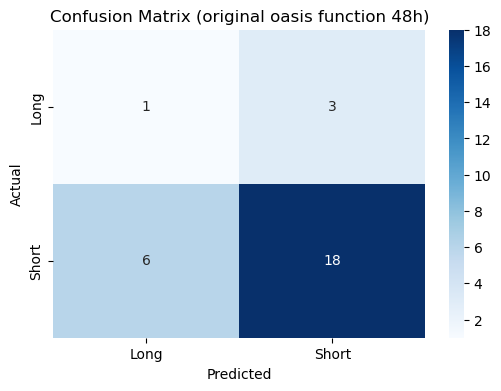

In [1102]:
# Split the dataset into train and test
X = oasis_48[['oasis_score']]  #Features: OASIS score
y = oasis_48['los_label']  # Target: LOS label (short/long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

cm1 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['Long', 'Short'], yticklabels=['Long', 'Short'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (original oasis function 48h)')
plt.show()

#### 24h modified OASIS function predictions

              precision    recall  f1-score   support

        long       0.18      0.50      0.27         4
       short       0.88      0.62      0.73        24

    accuracy                           0.61        28
   macro avg       0.53      0.56      0.50        28
weighted avg       0.78      0.61      0.67        28



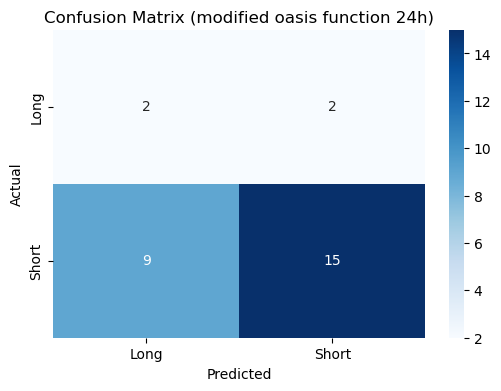

In [1103]:
# Split the dataset into train and test
X = oasis_24_mod[['oasis_score']]  #Features: OASIS score
y = oasis_24_mod['los_label']  # Target: LOS label (short/long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

cm2 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=['Long', 'Short'], yticklabels=['Long', 'Short'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (modified oasis function 24h)')
plt.show()

#### 48h modified OASIS function prediction

              precision    recall  f1-score   support

        long       0.17      0.25      0.20         4
       short       0.86      0.79      0.83        24

    accuracy                           0.71        28
   macro avg       0.52      0.52      0.51        28
weighted avg       0.76      0.71      0.74        28



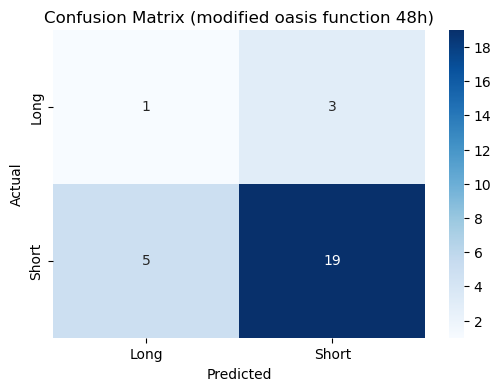

In [1104]:
# Split the dataset into train and test
X = oasis_48_mod[['oasis_score']]  #Features: OASIS score
y = oasis_48_mod['los_label']  # Target: LOS label (short/long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

cm3 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=['Long', 'Short'], yticklabels=['Long', 'Short'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (modified oasis function 48h)')
plt.show()

Best accuracy (0.79) with modified OASIS function for first 48 hours in ICU, but still bad since the model isn't predicting long stays very well. Let's see if we can improve it...

### ALTERNATIVE prediction using the values of some variables

#### 24h prediction

In [1105]:
df_icustays['los_label'] = df_icustays['los'].apply(lambda x: 'long' if x >= 4 else 'short')

In [1106]:
merged_df_24 = pd.concat([temperature_df_24h, heartrate_df_24h, resprate_df_24h, map_df_24h, gcs_df_24_min, urine_df_24h, vent_df_24h], 
axis=0, join='outer')

merged_df_24 = merged_df_24.merge(age_df, on = ['subject_id', 'hadm_id', 'stay_id'] )
merged_df_24 = merged_df_24.merge(prelos_df, on = ['subject_id', 'hadm_id', 'stay_id'] )
merged_df_24 = merged_df_24.merge(elective_surg_df, on = ['subject_id', 'hadm_id', 'stay_id'] )

merged_df_24 = merged_df_24.drop(columns=[col for col in merged_df_24.columns if col.endswith("_time")])

In [1107]:
# Merge with df_icustays to add 'los_binary'
merged_df_24 = merged_df_24.merge(df_icustays[["subject_id", "hadm_id", "stay_id", "los_label"]], 
                                             on=["subject_id", "hadm_id", "stay_id"], 
                                             how="left")


print(merged_df_24.shape)
merged_df_24.head()

(10889, 14)


,subject_id,hadm_id,stay_id,temp_c,hrate,resp_rate,MAP,GCS_total,urine,ventilated,age,prelos,admission_type,los_label
0,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,short
1,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,short
2,10005817,20626031,32604416,37.1,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,short
3,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,short
4,10005817,20626031,32604416,37.1,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,short


Cross-validation accuracy scores: [0.99724518 0.99586777 0.99770432 0.99862259 0.99310978]
Mean accuracy: 0.9965
Confusion Matrix:


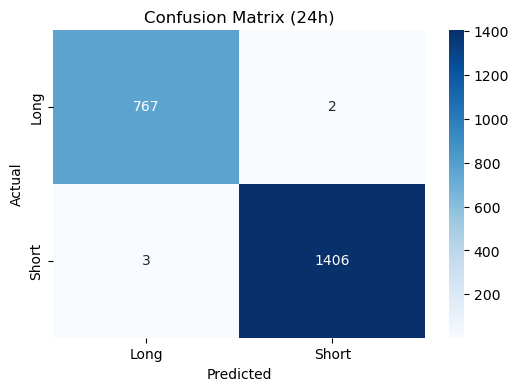

In [1113]:
icu_variables = ['hrate', 'temp_c', 'MAP', 'resp_rate', 'GCS_total', 'age', 'prelos', 'urine']

X = merged_df_24.drop(columns=["subject_id", "hadm_id", "stay_id", 'ventilated', 'admission_type', "los_label"])
y = merged_df_24["los_label"]

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

model = RandomForestClassifier(n_estimators=100, random_state=42
                               )
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Long', 'Short'], yticklabels=['Long', 'Short'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (24h)')
plt.show()


#### 48h prediction

In [1109]:
merged_df_48 = pd.concat([temperature_df_48h, heartrate_df_48h, resprate_df_48h, map_df_48h, gcs_df_48_min, urine_df_48h, vent_df_48h], 
axis=0, join='outer')

merged_df_48 = merged_df_48.merge(age_df, on = ['subject_id', 'hadm_id', 'stay_id'] )
merged_df_48 = merged_df_48.merge(prelos_df, on = ['subject_id', 'hadm_id', 'stay_id'] )
merged_df_48 = merged_df_48.merge(elective_surg_df, on = ['subject_id', 'hadm_id', 'stay_id'] )

merged_df_48 = merged_df_48.drop(columns=[col for col in merged_df_48.columns if col.endswith("_time")])

In [1110]:
# Merge with df_icustays to add 'los_binary'
merged_df_48 = merged_df_48.merge(df_icustays[["subject_id", "hadm_id", "stay_id", "los_label"]], 
                                             on=["subject_id", "hadm_id", "stay_id"], 
                                             how="left")


print(merged_df_48.shape)
merged_df_48.head()

(17113, 14)


,subject_id,hadm_id,stay_id,temp_c,hrate,resp_rate,MAP,GCS_total,urine,ventilated,age,prelos,admission_type,los_label
0,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,short
1,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,short
2,10005817,20626031,32604416,37.1,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,short
3,10005817,20626031,32604416,37.0,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,short
4,10005817,20626031,32604416,37.1,NaN,NaN,NaN,NaN,NaN,NaN,66,79.766944,urgent,short


Cross-validation accuracy scores: [0.99766287 0.99795501 0.99737073 0.99795441 0.99824664]
Mean accuracy: 0.9978
Confusion Matrix:


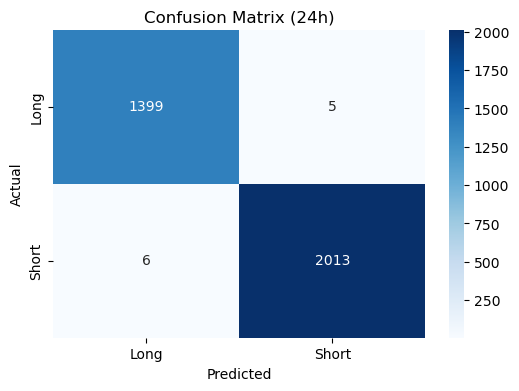

In [1112]:
icu_variables = ['hrate', 'temp_c', 'MAP', 'resp_rate', 'GCS_total', 'age', 'prelos', 'urine']

X = merged_df_48.drop(columns=["subject_id", "hadm_id", "stay_id", 'ventilated', 'admission_type', "los_label"])
y = merged_df_48["los_label"]

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

model = RandomForestClassifier(n_estimators=100, random_state=42
                               )
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Long', 'Short'], yticklabels=['Long', 'Short'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (24h)')
plt.show()


#### 3. Conclusions

Using the values of variables from the first hours of the ICU stay improved the model's predictions by a lot! The accuracy is up to 0.9978 at best. The better accuracy scores, both from the model using OASIS and using other variables, came from the first 48h.  False positives in this scenario are dangerous because if we are predicting a short stay in place of an actual long stay, we may jeaporadize the care of some patients who are at higher risk of being more severely ill, so it is important that the model is as accurate as possible. 